In [87]:
    ##Borrar datos del entorno
rm(list=ls())


#Se utiliza pacman para instalar y cargar paquetes
if(!require('pacman')) install.packages('pacman')
pacman::p_load(tidyverse,srvyr,googledrive,janitor,survey,
               showtext,sf, httr,jsonlite,gt)
#Fuente para los gráficos
font_add_google("Montserrat", "pop")
showtext_auto()

## Funciones para ahorrar código

In [88]:
#Función para consultar la api

consulta_api<-function(url){
  r <- GET(url, timeout(10000))
  df <- fromJSON(rawToChar(r$content))
  return(df)
}

In [89]:
#Función para crear mapas
crea_mapa <- function(df, custom_palette, titulo,geodataframe) {
  library(tidyverse)
  library(sf)


datos_planos<-df%>%
#Crear periodos
mutate(periodo=case_when(año>=2013 & año<=2018~"2013-2018",
                        año>=2019 & año<=2023~"2019-2023"))%>%
group_by(periodo,estado)%>%
summarise(acciones=sum(acciones),monto=sum(monto))%>%
ungroup()%>%
#Crear distribución porcentual
group_by(periodo)%>%
mutate(porcentaje=round(acciones/sum(acciones)*100,2))%>%
ungroup()%>%
#Crear cortes para la distribución
mutate(acciones_cat=cut(porcentaje,breaks=5, dig.lab=2))%>%
 #Formato de etiquetas
  mutate(
    etiquetas = if_else(
      str_detect(acciones_cat, "^\\([-]"), 
      str_replace(as.character(acciones_cat), "^\\(\\-", "("), 
      as.character(acciones_cat) 
    ),
  #Guión en lugar de coma
  etiquetas = str_replace(etiquetas, ",", "-"),
  etiquetas = str_replace(etiquetas, "\\]$", ")") 
)%>%
#Unir con geodataframe
left_join(geodataframe, by = c("estado" = "state_name"))

geodata<-datos_planos%>%
st_as_sf()

#Crear mapa
  ggplot() +
  # Capa con datos de los municipios
  geom_sf(data=geodata,aes(fill = etiquetas),
          colour = "#ffffff", size = 0.07) +
  # Agrega título, subtítulo y fuente
  labs(title = titulo,
       subtitle="(Porcentaje)",
       caption = "
Fuente: SEDATU. Sistema Nacional de Información e Indicadores de Vivienda (SNIIV).") +
  scale_fill_manual("%",values = custom_palette)+
  guides(fill = guide_legend(reverse = TRUE)) +
    theme_void()+
  theme(plot.title = element_text(hjust = 0, size=25,face="bold"),
        plot.subtitle = element_text(hjust = 0, size=20, face="italic"),
        plot.caption = element_text(hjust = 0,size=15),
        legend.position="right",
        #Fuente y tamaño
        text=element_text("pop",
                          size=20))+
    facet_wrap(~periodo)

}

In [90]:
#Función para crear tabla
crea_tabla <- function(df, titulo, subtitulo,nota="",nombre_archivo){
  library(gt)
  library(dplyr)
  library(magick)
 
  # Format the numeric columns with commas
  formatted_df <- df %>%
    mutate(across(where(is.numeric), ~scales::comma(.)))

  # Checa si existe la columna "Organismo" para agrupar la tabla
  if("Organismo" %in% names(df)) {
    gt_table <- formatted_df %>%
      gt(rowname_col = "Organismo",
         groupname_col = "Año",
         row_group_as_column = TRUE)
  } else {
    gt_table <- formatted_df %>%
      gt()
  }
  
  gt_table <- gt_table %>%
    tab_options(
      column_labels.font.weight = "bold",
    ) %>%
    tab_header(
      title = md(paste0("**", titulo, "**")),
subtitle=md(paste0("*", subtitulo, "*"))
    ) %>%
    tab_options(
      table.font.names = 'Poppins',
      source_notes.font.size = 8,
      table.border.top.width = px(0),
      table.border.bottom.width = px(0),
      column_labels.background.color = "#235b4eff",
  column_labels.font.size = 10,
    ) %>%
    cols_align(
      align = "center"
    ) %>%
    tab_source_note(
      source_note = md("Nota: Cifras preliminares.")
    ) %>%
tab_source_note(
      source_note = md(nota)
    ) %>%
    tab_source_note(
      source_note = md("Fuente: SEDATU. Sistema Nacional de Información e Indicadores de Vivienda (SNIIV).")
    )%>%
  cols_width(
    everything() ~ px(80)
  )

  # Salva la tabla
  gtsave(gt_table, filename = nombre_archivo)

  # Muestra la imagen
  img <- image_read(nombre_archivo)
  return(img)
}

In [91]:
#Función para agrupar datos de manera anual
agrupa_dato_anual <- function(df, columna_tipo_dato) {
  library(dplyr)
#Condición de agrupación  
  if("organismo" %in% names(df)) {
    grouped_df <- df %>%
      group_by(año, organismo)
  } else {
    grouped_df <- df %>%
      group_by(año)
  }
  
  result_df <- grouped_df %>%
    summarise(
      monto = round(sum(monto) / 1000000, 1),
      acciones = sum(acciones),
      .groups = 'drop' 
    ) %>%
    mutate(año = as.character(año)) %>%
    rename(
      "Año" = año,
      "Monto (millones de pesos)" = monto,
      !!columna_tipo_dato := acciones
    )
 
 
 #Renombrar organismo 
  if("organismo" %in% names(df)) {
    result_df <- result_df %>%
      rename("Organismo" = organismo)
  }
  
  return(result_df)
}


In [92]:
#Función para actualizar los precios

actualiza_precios<-function(df,tabla_inpc){

df<-df%>%
#Pegar con tabla de inpc
left_join(tabla_inpc, by = c("Año" = "año"))%>%
#Calcular precios actualizados
#Utilizar columna Monto (millones de pesos) y multiplicar por el inpc correspondiente
mutate(monto_actualizado=round(`Monto (millones de pesos)`*inpc23/100,2))

return(df)

}

In [93]:
paleta<-rev(c("#691c32ff", "#901d3dff","#ac2540ff","#c88f80ff","#e3c8a6ff"))

## Cartografía para generar los mapas

In [94]:
estados<-st_read("https://raw.githubusercontent.com/strotgen/mexico-leaflet/master/states.geojson")%>%
  #Renombrar Distrito Federal como Ciudad de México
mutate(state_name=case_when(state_name=="Distrito Federal" ~ "Ciudad de México",
TRUE ~ state_name))

Reading layer `states' from data source 
  `https://raw.githubusercontent.com/strotgen/mexico-leaflet/master/states.geojson' 
  using driver `GeoJSON'
Simple feature collection with 32 features and 3 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -118.4 ymin: 14.5321 xmax: -86.72404 ymax: 32.71865
Geodetic CRS:  WGS 84


### Índice Nacional de Precios al Consumidor

In [95]:
url_inegi<-"https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/628194/es/0700/false/BIE/2.0/ef8c858c-1f87-6408-5630-fb5496f609bf/?type=json"

In [96]:
inpc<-consulta_api(url_inegi)%>%
pluck("Series")%>%
pluck("OBSERVATIONS")%>%
as.data.frame()%>%
janitor::clean_names()%>%
#Filtrar fecha
filter(time_period >= "2013/01" & time_period <= "2023/12")%>%
mutate(obs_value=as.numeric(obs_value))%>%
#Extrar mes y año de la variable time_period
separate(time_period, into = c("año", "mes"), sep = "/")%>%
#Dejar solo los datos de diciembre
filter(mes=="12")%>%
arrange(año)%>%
select(año,mes,obs_value)%>%
mutate(
#Cambiar base a 2023
inpc23=obs_value/obs_value[11]*100)
inpc

año,mes,obs_value,inpc23
<chr>,<chr>,<dbl>,<dbl>
2013,12,83.77006,63.28334
2014,12,87.18898,65.86614
2015,12,89.04682,67.26962
2016,12,92.03903,69.53007
2017,12,98.27288,74.23937
2018,12,103.02000,77.82554
2019,12,105.93400,80.02689
2020,12,109.27100,82.54780
2021,12,117.30800,88.61928


## Subsidios

In [97]:
url="https://qa-sniiv.sedatu.gob.mx/api/CuboAPI/GetFinanciamiento/2013,2023/0/0/anio,organismo,estado"

In [98]:
df<-consulta_api(url)%>%
arrange(año)%>%
  #Filtrar por organismo
  filter(organismo=="CONAVI")%>%
select(-organismo)

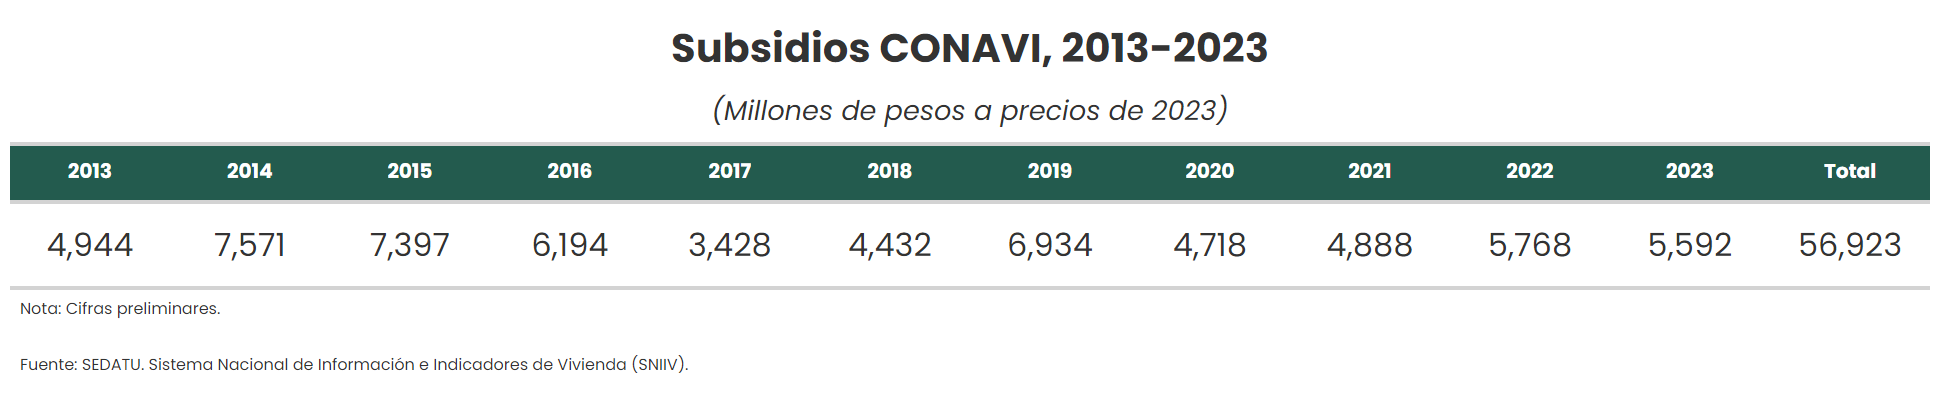

# A tibble: 1 × 7
  format width height colorspace matte filesize density
  <chr>  <int>  <int> <chr>      <lgl>    <int> <chr>  
1 PNG     1940    396 sRGB       TRUE     59754 72x72  

In [99]:
df%>%
agrupa_dato_anual("Subsidios")%>%
actualiza_precios(inpc)%>%
select(Año, monto_actualizado)%>%
rename("Monto (millones de pesos)" = monto_actualizado)%>%
pivot_wider(names_from = "Año", values_from = "Monto (millones de pesos)")%>%
janitor::adorn_totals(where = "col")%>%


#Crear tabla
crea_tabla("Subsidios CONAVI, 2013-2023","(Millones de pesos a precios de 2023)","","subsidios_monto.png")

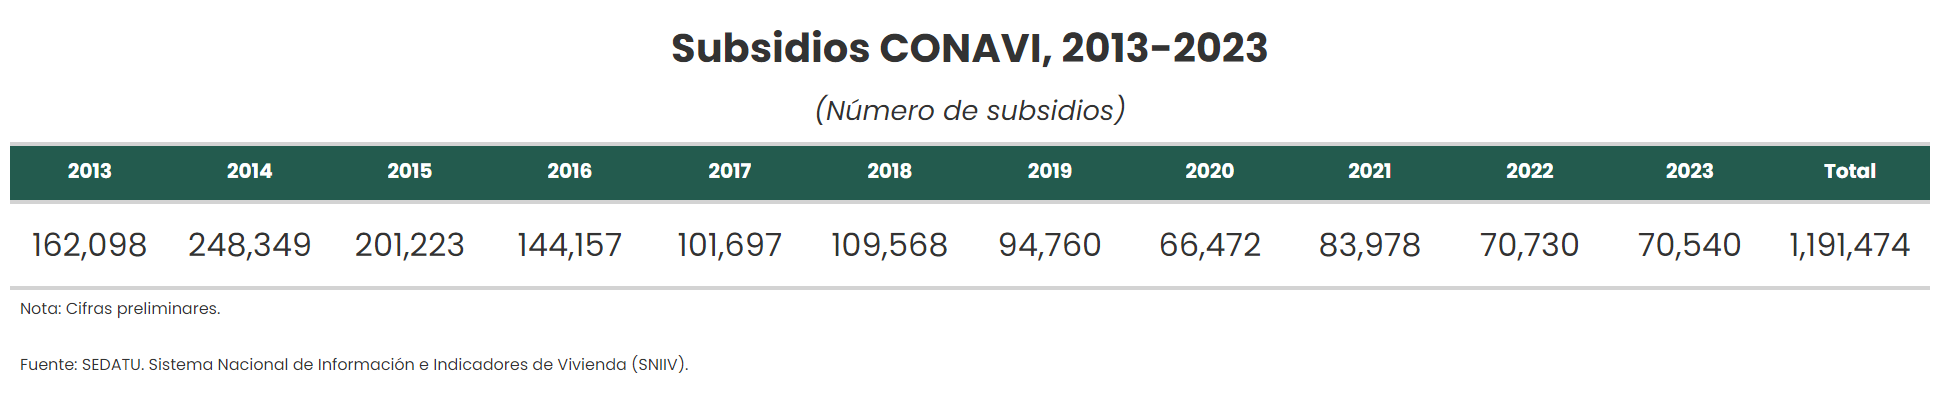

# A tibble: 1 × 7
  format width height colorspace matte filesize density
  <chr>  <int>  <int> <chr>      <lgl>    <int> <chr>  
1 PNG     1940    396 sRGB       TRUE     56652 72x72  

In [100]:
df%>%
agrupa_dato_anual("Subsidios")%>%
actualiza_precios(inpc)%>%
select(Año, Subsidios)%>%
rename("Subsidios" = Subsidios)%>%
pivot_wider(names_from = "Año", values_from = "Subsidios")%>%
janitor::adorn_totals(where = "col")%>%
#Crear tabla
crea_tabla("Subsidios CONAVI, 2013-2023","(Número de subsidios)",,"subsidios_act.png")

### Mapa

`summarise()` has grouped output by 'periodo'. You can override using the
`.groups` argument.


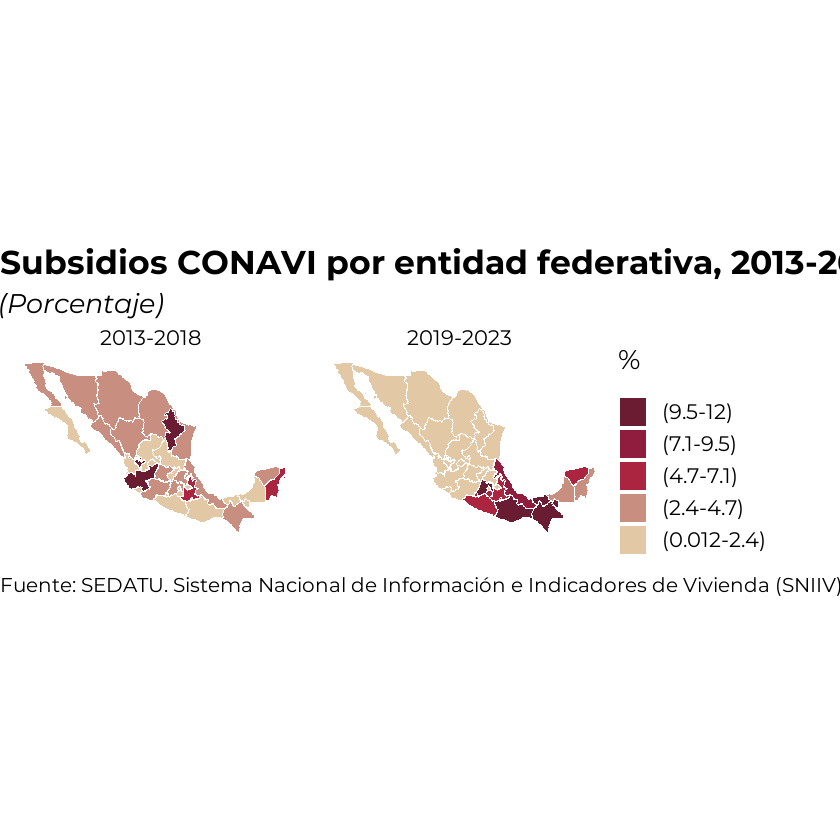

In [101]:
#Crear mapa
crea_mapa(df, paleta, "Subsidios CONAVI por entidad federativa, 2013-2023",estados)

## Financiamientos

In [102]:
url="https://qa-sniiv.sedatu.gob.mx/api/CuboAPI/GetFinanciamiento/2013,2023/0/0/anio,organismo,estado"

In [103]:
df<-consulta_api(url)%>%
arrange(año)%>%
  #Filtrar por organismo
  filter(organismo=="INFONAVIT" | organismo=="FOVISSSTE" | organismo=="SHF (FONDEO)")%>%
#Renombrar SHF (FONDEO) como SHF
mutate(organismo=case_when(organismo=="SHF (FONDEO)"~"SHF",
TRUE~organismo))
head(df,5)

,año,estado,organismo,acciones,monto
,<int>,<chr>,<chr>,<int>,<dbl>
1,2013,Aguascalientes,FOVISSSTE,1352,549064571
2,2013,Baja California,FOVISSSTE,1367,728367073
3,2013,Baja California Sur,FOVISSSTE,1777,789676448
4,2013,Campeche,FOVISSSTE,353,160515286
5,2013,Coahuila de Zaragoza,FOVISSSTE,1343,623977285


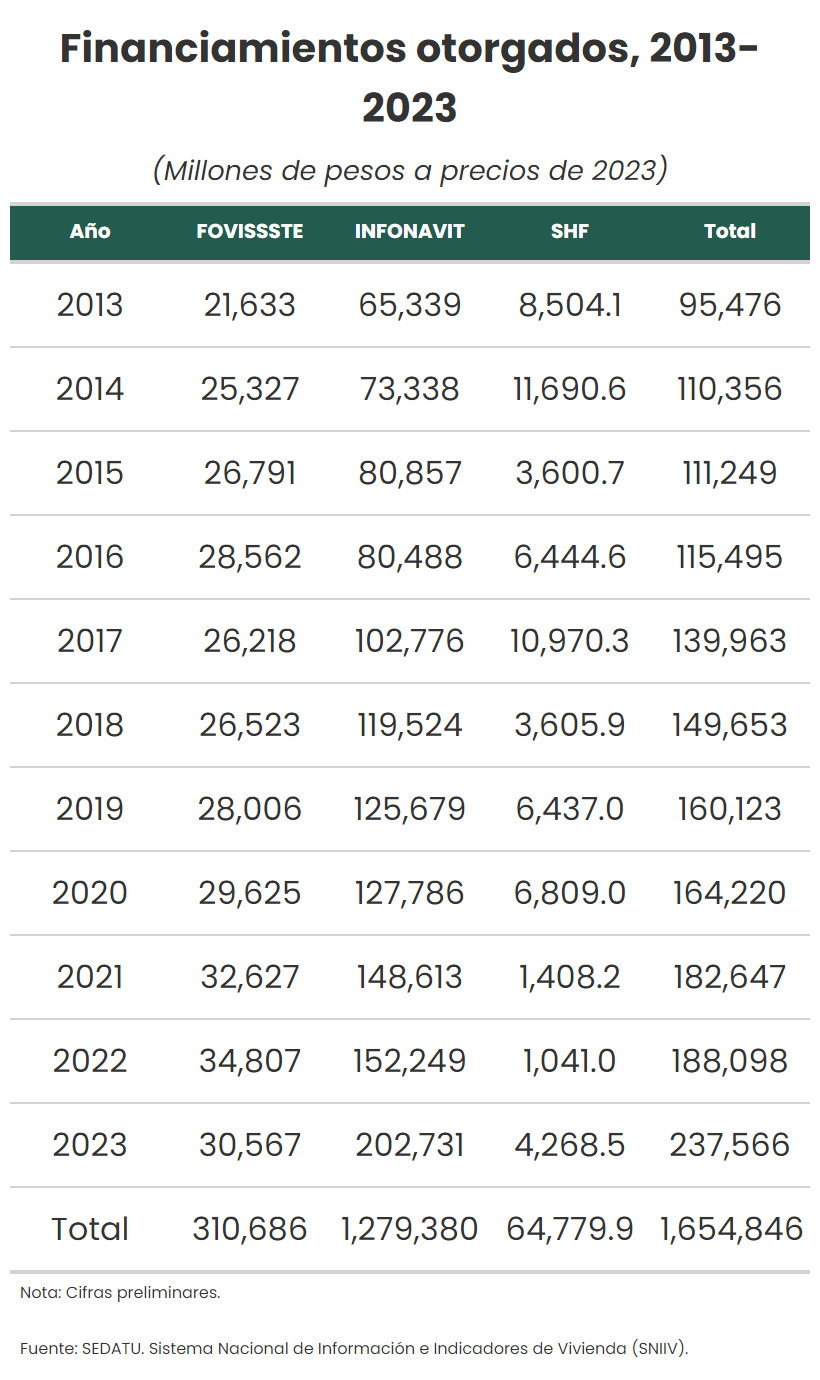

# A tibble: 1 × 7
  format width height colorspace matte filesize density
  <chr>  <int>  <int> <chr>      <lgl>    <int> <chr>  
1 PNG      820   1380 sRGB       TRUE    155204 72x72  

In [104]:
df%>%
agrupa_dato_anual("Financiamientos")%>%
actualiza_precios(inpc)%>%
select(Año, Organismo, monto_actualizado)%>%
rename("Monto (millones de pesos)" = monto_actualizado)%>%
pivot_wider(names_from = "Organismo", values_from = "Monto (millones de pesos)")%>%
janitor::adorn_totals(where = "row")%>%
janitor::adorn_totals(where = "col")%>%
#Crear tabla
crea_tabla("Financiamientos otorgados, 2013-2023","(Millones de pesos a precios de 2023)",,"financiamientos_monto.png")

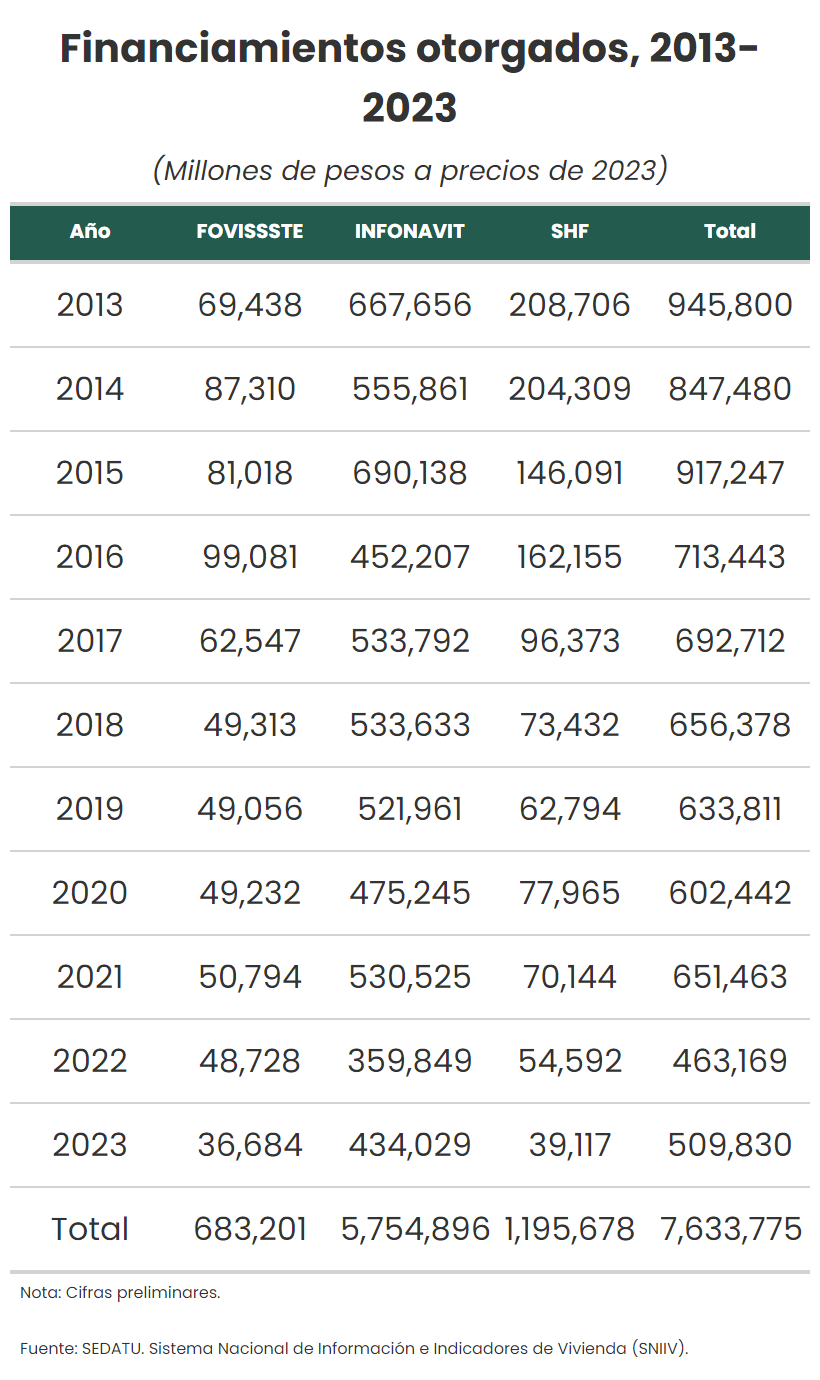

# A tibble: 1 × 7
  format width height colorspace matte filesize density
  <chr>  <int>  <int> <chr>      <lgl>    <int> <chr>  
1 PNG      820   1380 sRGB       TRUE    155504 72x72  

In [105]:
df%>%
agrupa_dato_anual("Financiamientos")%>%
actualiza_precios(inpc)%>%
select(Año, Organismo,Financiamientos)%>%
pivot_wider(names_from = "Organismo", values_from = "Financiamientos")%>%
janitor::adorn_totals(where = "row")%>%
janitor::adorn_totals(where = "col")%>%
#Crear tabla
crea_tabla("Financiamientos otorgados, 2013-2023","(Millones de pesos a precios de 2023)",,"financiamientos_acc.png")

### Mapa

`summarise()` has grouped output by 'periodo'. You can override using the
`.groups` argument.


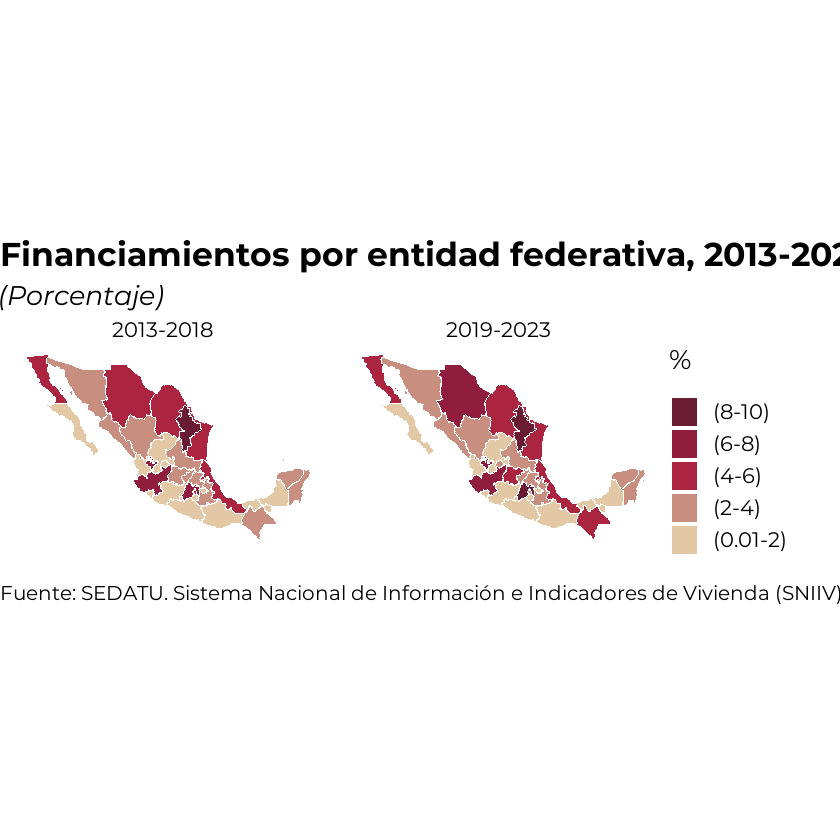

In [106]:
crea_mapa(df, paleta, "Financiamientos por entidad federativa, 2013-2023",estados)

## Acciones

In [107]:
url="https://qa-sniiv.sedatu.gob.mx/api/CuboAPI/GetFinanciamiento/2013,2023/0/0/anio,organismo,estado,tipo_credito"

In [108]:
df<-consulta_api(url)%>%
arrange(año)%>%
  #Filtrar por organismo
  filter(organismo=="INFONAVIT" | organismo=="FOVISSSTE" | organismo=="SHF (FONDEO)")%>%
  #Filtrar por tipo de crédito
  filter(tipo_credito=="Credito individual")

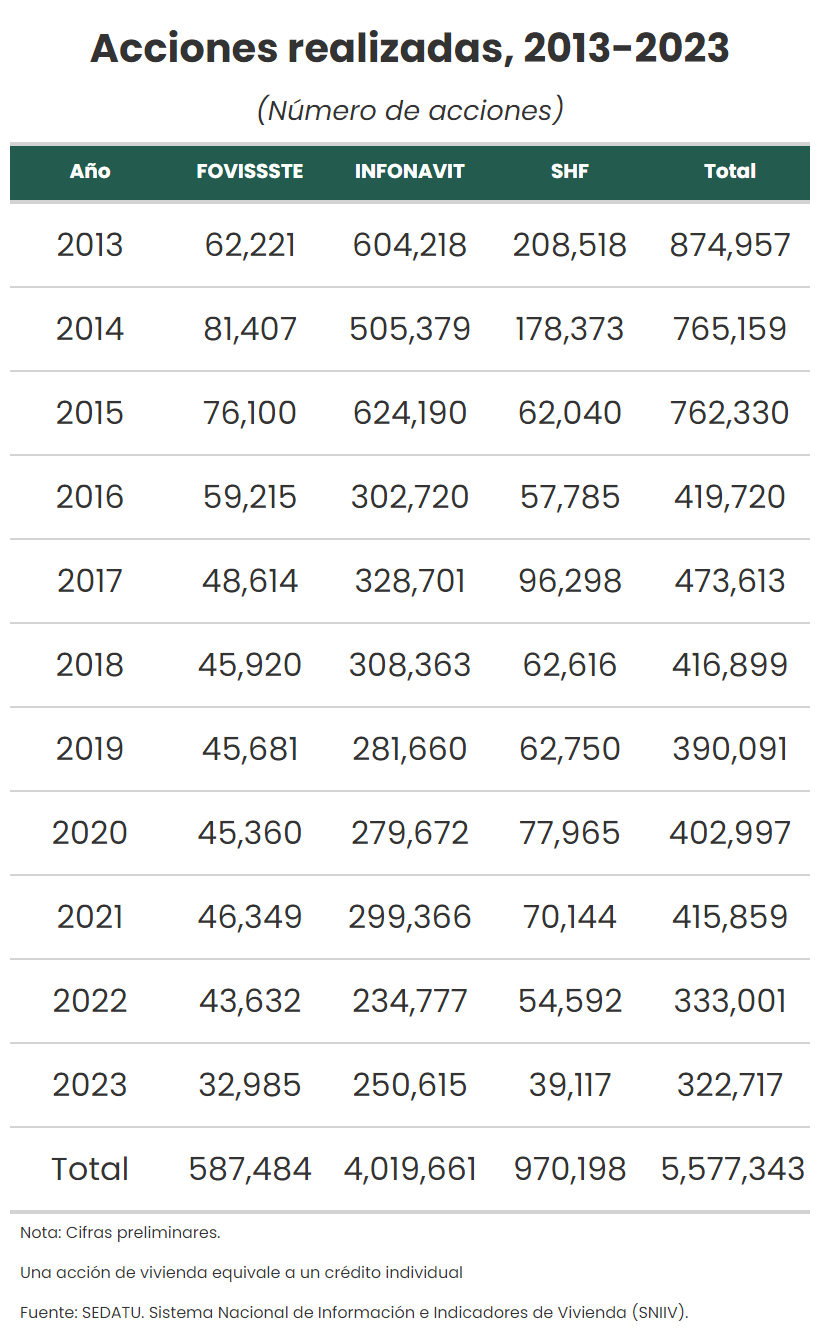

# A tibble: 1 × 7
  format width height colorspace matte filesize density
  <chr>  <int>  <int> <chr>      <lgl>    <int> <chr>  
1 PNG      820   1344 sRGB       TRUE    149703 72x72  

In [109]:
df%>%
agrupa_dato_anual("Acciones")%>%
actualiza_precios(inpc)%>%
select(Año, Organismo,Acciones)%>%
mutate(Organismo=case_when(Organismo=="SHF (FONDEO)"~"SHF",
                           TRUE~Organismo))%>%
pivot_wider(names_from = "Organismo", values_from = "Acciones")%>%

#Añadir suma de filas
janitor::adorn_totals(where = "col")%>%
janitor::adorn_totals(where = "row")%>%
#Crear tabla
crea_tabla("Acciones realizadas, 2013-2023","(Número de acciones)","Una acción de vivienda equivale a un crédito individual","acciones_act.png")

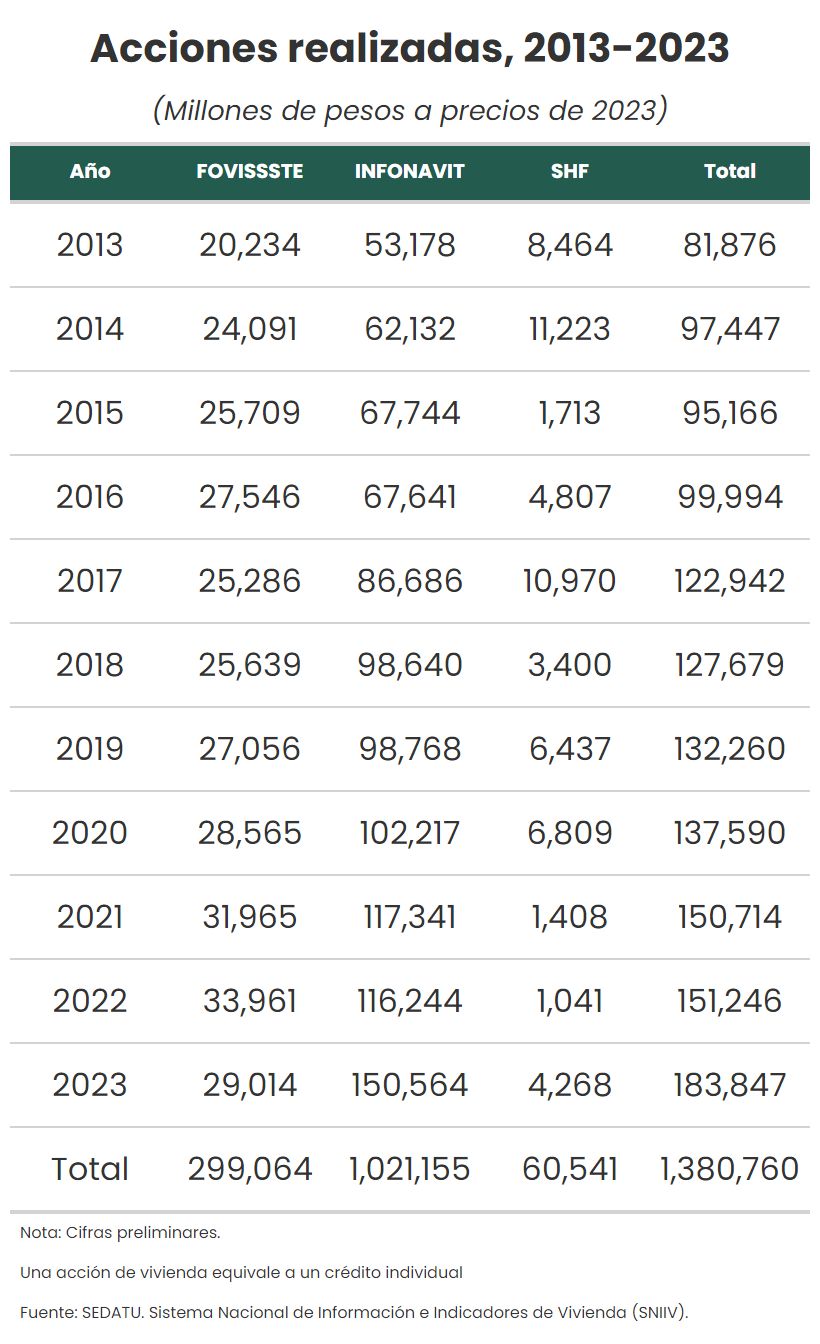

# A tibble: 1 × 7
  format width height colorspace matte filesize density
  <chr>  <int>  <int> <chr>      <lgl>    <int> <chr>  
1 PNG      820   1344 sRGB       TRUE    149978 72x72  

In [110]:
df%>%
agrupa_dato_anual("Acciones")%>%
actualiza_precios(inpc)%>%
select(Año, Organismo, monto_actualizado)%>%
mutate(Organismo=case_when(Organismo=="SHF (FONDEO)"~"SHF",
                           TRUE~Organismo))%>%
rename("Monto (millones de pesos)" = monto_actualizado)%>%

pivot_wider(names_from = "Organismo", values_from = "Monto (millones de pesos)")%>%

#Añadir suma de filas
janitor::adorn_totals(where = "col")%>%
janitor::adorn_totals(where = "row")%>%
#Crear tabla
crea_tabla("Acciones realizadas, 2013-2023","(Millones de pesos a precios de 2023)","Una acción de vivienda equivale a un crédito individual","acciones_monto.png")

`summarise()` has grouped output by 'periodo'. You can override using the
`.groups` argument.


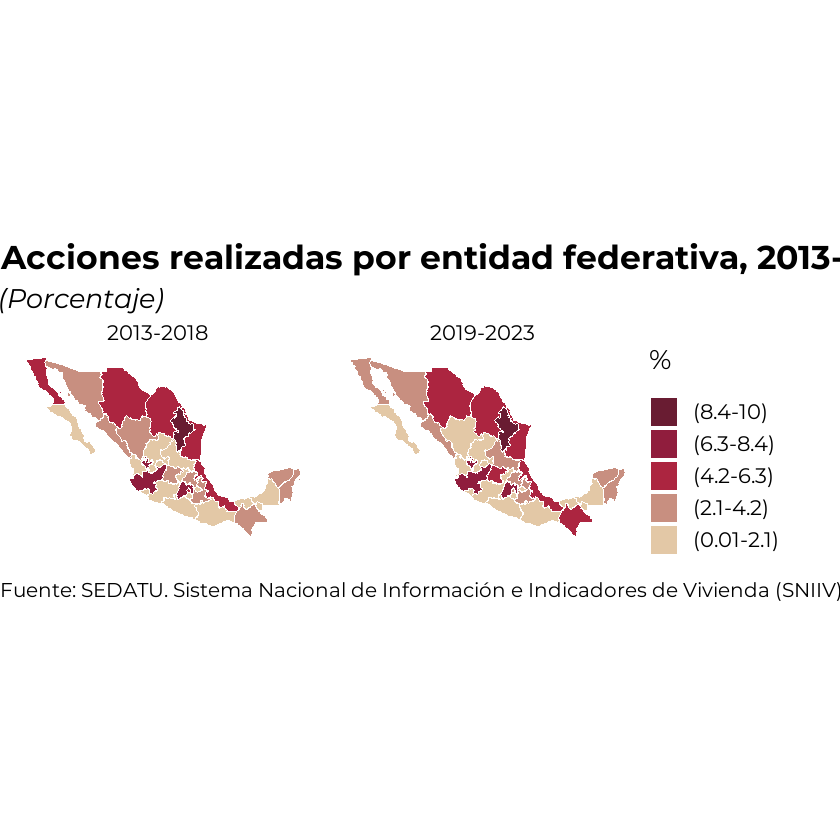

In [111]:
crea_mapa(df, paleta, "Acciones realizadas por entidad federativa, 2013-2023",estados)

## Autoproducción

In [112]:
#Url de financiamientos generales
url="https://sniiv.sedatu.gob.mx/api/CuboAPI/GetFinanciamiento/2013,2023/0/0/organismo,modalidad,tipo_credito,destino_credito,anio,mes"


In [113]:
finan_gral<-consulta_api(url)%>%
arrange(año)    

#### SHF

In [114]:
shf <- finan_gral %>%
  filter(organismo == "SHF (FONDEO)" &
         destino_credito %in% c("Autoproducción", "Ampliación", "Reconstrucción", "Mejoramientos"))%>%
group_by(año,organismo)%>%
summarise(acciones=sum(acciones),monto=sum(monto))
head(shf,5)

`summarise()` has grouped output by 'año'. You can override using the `.groups`
argument.


año,organismo,acciones,monto
<int>,<chr>,<int>,<dbl>
2013,SHF (FONDEO),193371,4071630032
2014,SHF (FONDEO),185801,6171274340
2015,SHF (FONDEO),144881,4112595003
2016,SHF (FONDEO),138559,3510084920
2017,SHF (FONDEO),42040,1386071703


#### FOVISSSTE

In [115]:
fovissste<-finan_gral%>%
filter(organismo=="FOVISSSTE" &
       destino_credito %in% c("Con disponibilidad de terreno"))%>%
group_by(año,organismo)%>%
summarise(acciones=sum(acciones),monto=sum(monto))
head(fovissste,5)

`summarise()` has grouped output by 'año'. You can override using the `.groups`
argument.


año,organismo,acciones,monto
<int>,<chr>,<int>,<dbl>
2013,FOVISSSTE,458,260863019
2014,FOVISSSTE,288,183484585
2015,FOVISSSTE,370,249692255
2016,FOVISSSTE,443,314446515
2017,FOVISSSTE,393,284284342


#### INFONAVIT

In [116]:
url_infonavit<-"https://sniiv.sedatu.gob.mx/api/CuboAPI/GetINFONAVIT/2013,2023/0/0/linea_credito,modalidad,esquema,mes,anio"

In [117]:
bdinfonavit<-consulta_api(url_infonavit)%>%
arrange(año)

In [118]:
infonavit<-bdinfonavit%>%
filter(linea_credito %in% c("Linea II", "Linea III","Linea IV"))%>%
filter(modalidad %in% c("Adquisicion de suelo", "Ampliación y rehabilitación","Autoconstrucción","Con disponibilidad de terreno"))%>%
group_by(año)%>%
summarise(acciones=sum(acciones),monto=sum(monto))%>%
mutate(organismo="INFONAVIT")
head(infonavit,5)

año,acciones,monto,organismo
<int>,<int>,<dbl>,<chr>
2015,298874,1393418193,INFONAVIT
2016,87347,1528149038,INFONAVIT
2017,154158,2752454237,INFONAVIT
2018,184164,3635192439,INFONAVIT
2019,192118,5121118316,INFONAVIT


#### CONAVI

In [119]:
url_conavi<-"https://sniiv.sedatu.gob.mx/api/CuboAPI/GetCONAVI/2013,2023/0/0/modalidad,anio"

In [120]:
bdconavi<-consulta_api(url_conavi)%>%
arrange(año)

In [122]:
str(bdconavi)

'data.frame':	69 obs. of  4 variables:
 $ año      : int  2013 2013 2013 2013 2013 2013 2014 2014 2014 2014 ...
 $ modalidad: chr  "Autoproducción" "Lote con servicios" "Mejoramiento" "Reconstrucción" ...
 $ acciones : int  25619 2107 25305 1449 98583 9035 16441 0 437 74337 ...
 $ monto    : num  1.16e+09 4.15e+07 3.20e+08 1.99e+08 5.57e+09 ...


In [123]:
unique(bdconavi$modalidad)

[1] "Autoproducción"     "Lote con servicios" "Mejoramiento"      
 [4] "Reconstrucción"     "Vivienda nueva"     "Vivienda existente"
 [7] "Contragarantías"    "Renta"              "Ampliación"        
[10] "Autoconstrucción"

In [124]:
conavi<-bdconavi%>%
filter(modalidad %in% c("Autoproducción", "Autoconstrucción", "Ampliación", "Mejoramiento","Reconstrucción","Vivienda existente"))%>%
group_by(año)%>%
summarise(acciones=sum(acciones),monto=sum(monto))%>%
mutate(organismo="CONAVI")


conavi


año,acciones,monto,organismo
<int>,<int>,<dbl>,<chr>
2013,61408,2203651440,CONAVI
2014,110944,3237407685,CONAVI
2015,53137,2357127383,CONAVI
2016,21150,1298526024,CONAVI
2017,20452,1215401220,CONAVI
2018,41902,2013878105,CONAVI
2019,79069,7207555864,CONAVI
2020,63380,5086441542,CONAVI
2021,82034,4822026398,CONAVI


In [125]:
#Crear tabla final
autoproduccion<-bind_rows(shf,fovissste,infonavit,conavi)

`summarise()` has grouped output by 'año'. You can override using the `.groups`
argument.


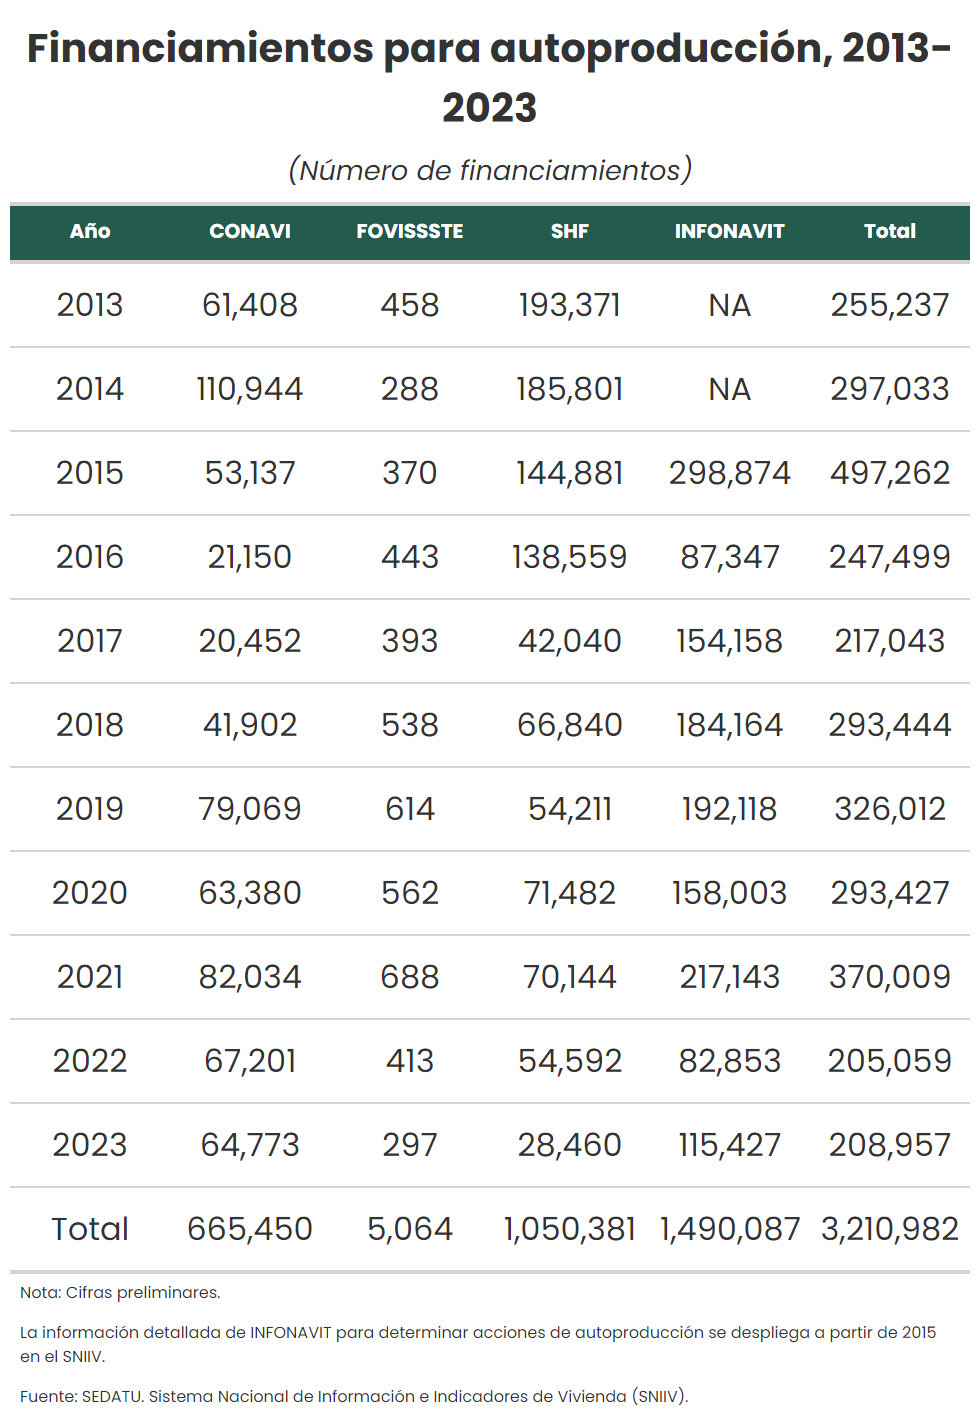

# A tibble: 1 × 7
  format width height colorspace matte filesize density
  <chr>  <int>  <int> <chr>      <lgl>    <int> <chr>  
1 PNG      980   1428 sRGB       TRUE    173457 72x72  

In [126]:
autoproduccion%>%
group_by(año, organismo)%>%
summarise(acciones=sum(acciones),monto=sum(monto))%>%
ungroup()%>%
mutate(organismo=case_when(organismo=="SHF (FONDEO)"~"SHF",
                           TRUE~organismo))%>%
agrupa_dato_anual("Acciones")%>%
actualiza_precios(inpc)%>%
select(Año, Organismo, Acciones)%>%
pivot_wider(names_from = "Organismo", values_from = "Acciones")%>%
#Añadir suma de filas
janitor::adorn_totals(where = "col")%>%
janitor::adorn_totals(where = "row")%>%
crea_tabla("Financiamientos para autoproducción, 2013-2023","(Número de financiamientos)","La información detallada de INFONAVIT para determinar acciones de autoproducción se despliega a partir de 2015 en el SNIIV.","autoproduccion_act.png")

`summarise()` has grouped output by 'año'. You can override using the `.groups`
argument.


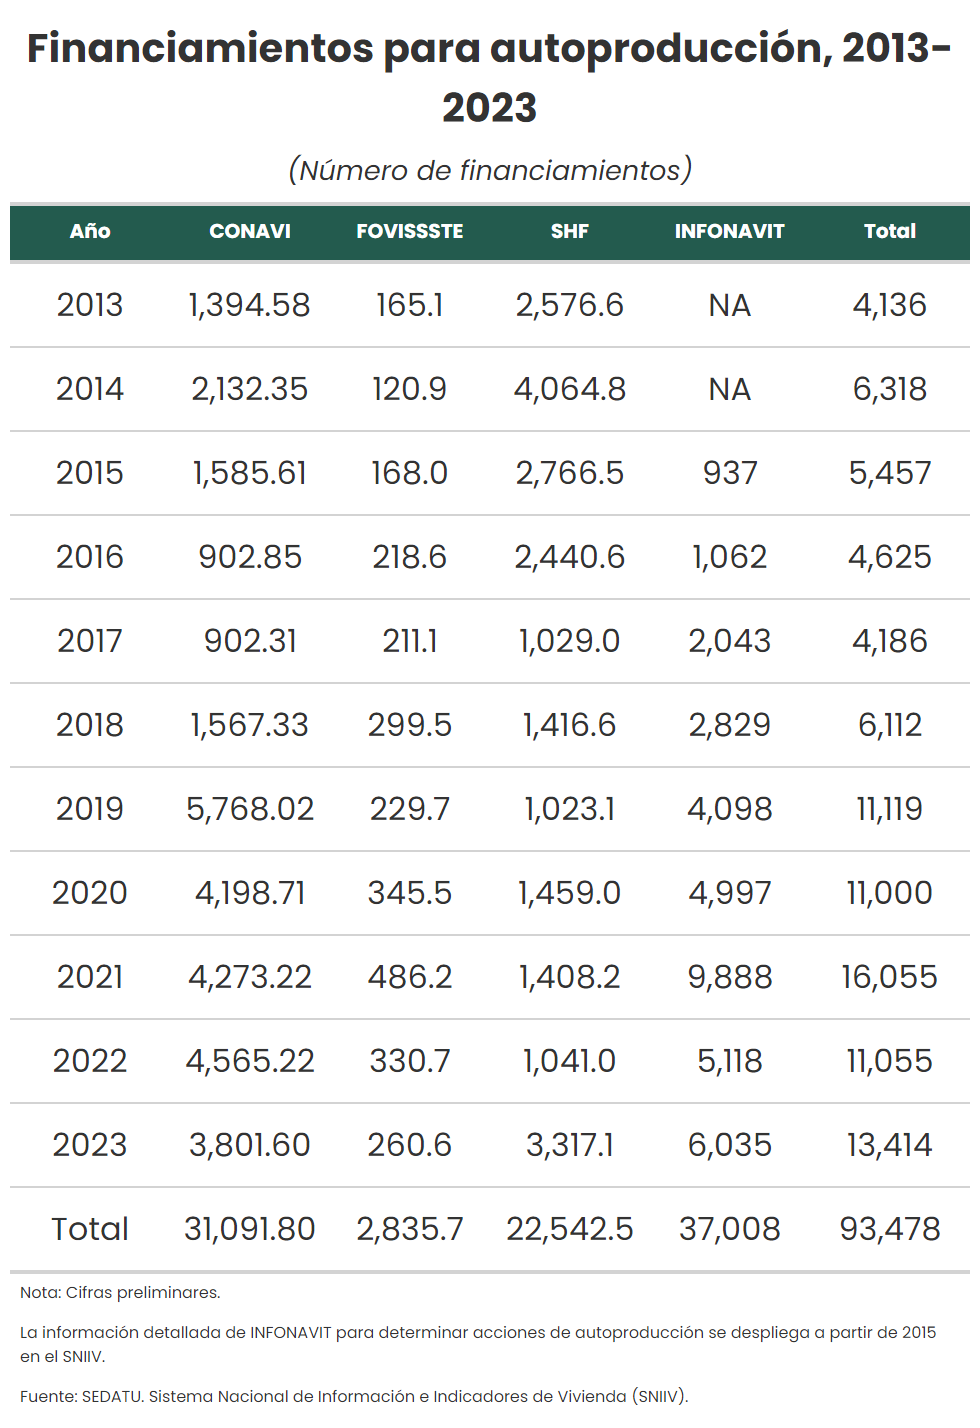

# A tibble: 1 × 7
  format width height colorspace matte filesize density
  <chr>  <int>  <int> <chr>      <lgl>    <int> <chr>  
1 PNG      980   1428 sRGB       TRUE    166007 72x72  

In [127]:
autoproduccion%>%
group_by(año, organismo)%>%

summarise(acciones=sum(acciones),monto=sum(monto))%>%
ungroup()%>%
mutate(organismo=case_when(organismo=="SHF (FONDEO)"~"SHF",
                           TRUE~organismo))%>%
agrupa_dato_anual("Acciones")%>%
actualiza_precios(inpc)%>%
select(Año, Organismo, monto_actualizado)%>%
rename("Monto (millones de pesos)" = monto_actualizado)%>%
pivot_wider(names_from = "Organismo", values_from = "Monto (millones de pesos)")%>%

#Añadir suma de filas
janitor::adorn_totals(where = "col")%>%
janitor::adorn_totals(where = "row")%>%
crea_tabla("Financiamientos para autoproducción, 2013-2023","(Número de financiamientos)","La información detallada de INFONAVIT para determinar acciones de autoproducción se despliega a partir de 2015 en el SNIIV.","autoproduccion_monto.png")